In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from datetime import *
import nltk
nltk.download('all')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import glob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

In [151]:
! git clone https://github.com/Shreya369/We-R.git

fatal: destination path 'We-R' already exists and is not an empty directory.


# **DATA COLLECTION**

In [0]:
INvideos = pd.read_csv('We-R/YouTube_dataset/INvideos.csv')

In [0]:
#Load the json file to match the category IDs to their respective category
categories = pd.read_json("We-R/YouTube_dataset/IN_category_id.json")
arr = categories["items"]
items = len(arr)

ids = []
for i in range(len(arr)):
    ids.append(categories["items"][i]['id'])

names = []
for i in range(len(arr)):
    names.append(categories["items"][i]["snippet"]["title"])

category = dict()
for i in range(len(names)):
    category[int(ids[i])] = names[i]
category[29] = "Nonprofits & Activism"

INvideos['Categories'] = [category[x] for x in INvideos['category_id']]

In [154]:
INvideos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Categories
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,Film & Animation
1,zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",News & Politics
2,10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...,Entertainment
3,N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...,Comedy
4,kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...,Entertainment


#**DATA PREPROCESSING**

## *Data Cleaning*

In [155]:
INvideos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 17 columns):
video_id                  37352 non-null object
trending_date             37352 non-null object
title                     37352 non-null object
channel_title             37352 non-null object
category_id               37352 non-null int64
publish_time              37352 non-null object
tags                      37352 non-null object
views                     37352 non-null int64
likes                     37352 non-null int64
dislikes                  37352 non-null int64
comment_count             37352 non-null int64
thumbnail_link            37352 non-null object
comments_disabled         37352 non-null bool
ratings_disabled          37352 non-null bool
video_error_or_removed    37352 non-null bool
description               36791 non-null object
Categories                37352 non-null object
dtypes: bool(3), int64(5), object(9)
memory usage: 4.1+ MB


In [156]:
# we can see in the info that the description column has NaN values, so we fill it with empty string
INvideos['description'] = INvideos['description'].fillna("")
INvideos.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 17 columns):
video_id                  37352 non-null object
trending_date             37352 non-null object
title                     37352 non-null object
channel_title             37352 non-null object
category_id               37352 non-null int64
publish_time              37352 non-null object
tags                      37352 non-null object
views                     37352 non-null int64
likes                     37352 non-null int64
dislikes                  37352 non-null int64
comment_count             37352 non-null int64
thumbnail_link            37352 non-null object
comments_disabled         37352 non-null bool
ratings_disabled          37352 non-null bool
video_error_or_removed    37352 non-null bool
description               37352 non-null object
Categories                37352 non-null object
dtypes: bool(3), int64(5), object(9)
memory usage: 4.1+ MB


# *Data transformation*

In [157]:
# Transforming the date in publish_time to the same format as that of trending_date and adding columns for publishing hour and day.
INvideos["publishing_day"] = INvideos["publish_time"].apply(
    lambda x: datetime.strptime(x[:10], "%Y-%m-%d").date().strftime('%a'))
INvideos["publishing_hour"] = INvideos["publish_time"].apply(lambda x: x[11:13])

for i in range(len(INvideos['publish_time'])):
  INvideos.loc[i,'publish_time']=str(datetime.strptime(INvideos['publish_time'][i][:10],"%Y-%m-%d").year)+'.'+str(datetime.strptime(INvideos['publish_time'][i][:10],"%Y-%m-%d").day)+'.'+str(datetime.strptime(INvideos['publish_time'][i][:10],"%Y-%m-%d").month)
  INvideos.loc[i,'trending_date']='20'+INvideos['trending_date'][i]  

INvideos.head()


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,Categories,publishing_day,publishing_hour
0,kzwfHumJyYc,2017.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017.12.11,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...,Film & Animation,Sun,12
1,zUZ1z7FwLc8,2017.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017.13.11,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",News & Politics,Mon,05
2,10L1hZ9qa58,2017.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017.12.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...,Entertainment,Sun,15
3,N1vE8iiEg64,2017.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017.12.11,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...,Comedy,Sun,07
4,kJzGH0PVQHQ,2017.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017.13.11,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...,Entertainment,Mon,01


In [0]:
# Some settings for plots
PLOT_COLORS = ["#b58900", "#003f5c","#268bd2", "#0052CC", "#FF5722"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

# **EXPLORATORY DATA ANALYSIS**

# **More information on data**

## *Determining when the data was collected*

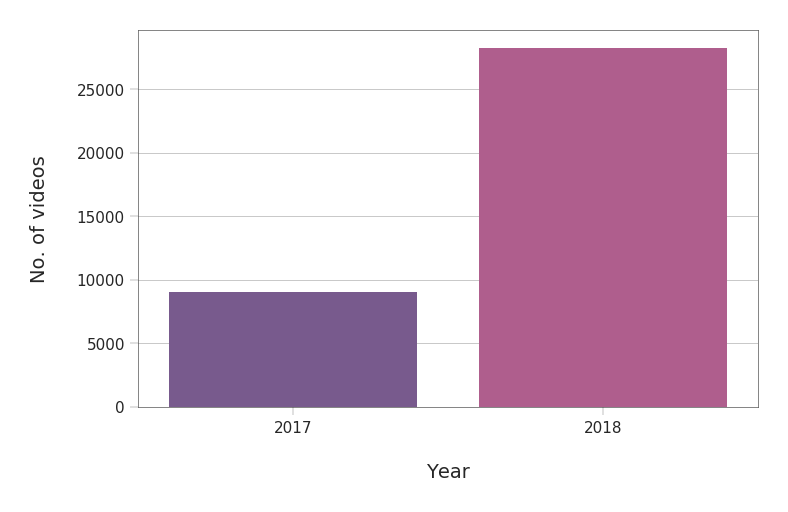

In [159]:

INvideo = INvideos['trending_date'].apply(lambda x: x[:4]).value_counts().to_frame().reset_index().rename(columns={"index":"year","trending_date":"No_of_videos"})

#plot the result
fig,ax = plt.subplots()
yrs = sns.barplot(x="year",y="No_of_videos",palette=sns.color_palette(['#7a5195', 
                                           '#bc5090'], n_colors=2),data=INvideo,ax=ax)
yrs = ax.set(xlabel='Year',ylabel='No. of videos')

In [160]:
#some statistics about the important features to know the range of variation of these features for the trending videos.
INvideos.describe()

,category_id,views,likes,dislikes,comment_count
count,37352.00,37352.00,37352.00,37352.00,37352.00
mean,21.58,1060477.65,27082.72,1665.08,2677.00
std,6.56,3184932.05,97145.10,16076.17,14868.32
min,1.00,4024.00,0.00,0.00,0.00
25%,23.00,123915.50,864.00,108.00,81.00
50%,24.00,304586.00,3069.00,326.00,329.00
75%,24.00,799291.25,13774.25,1019.25,1285.00
max,43.00,125432237.00,2912710.00,1545017.00,827755.00


####We can jot down important observations from the above statistics :

1. There are trending videos with 4024 views and there are ones with 125.4 million views !

2. There are trending videos with 0 likes to ones with 2.9 million likes.

3. There are trending videos with dislikes ranging from 0 to 1.5 million.

#**Content consumption in India**

## *Which are the common categories that goes viral ?*

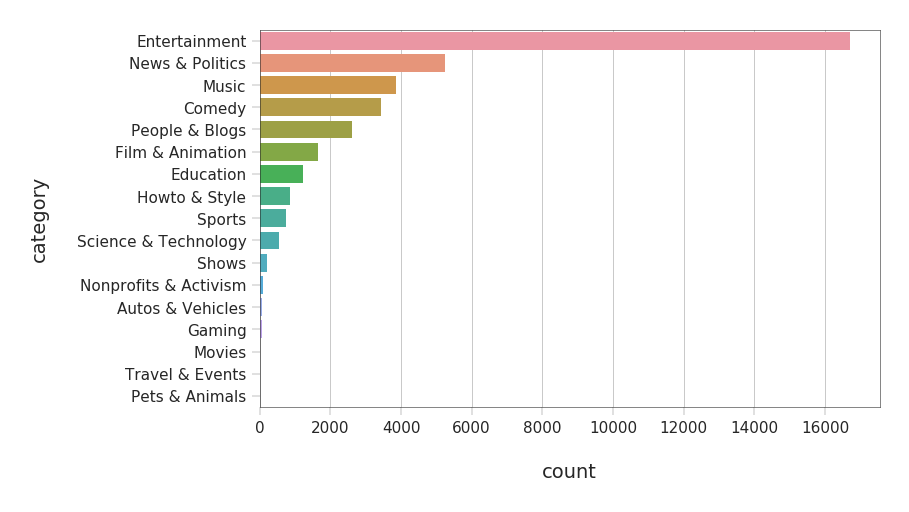

In [161]:
cat = INvideos['Categories'].value_counts().to_frame().reset_index().rename(columns={"index":"category","Categories":"count"})
sns.barplot(x="count",y="category",data = cat)

## *Which category of videos are viewed the most on an average ?*

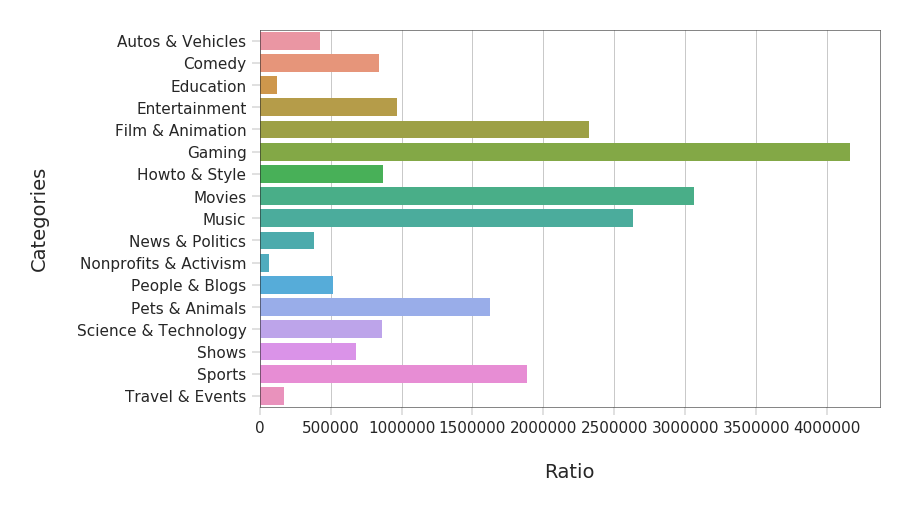

In [162]:
view = INvideos[["Categories","views"]]
view_df = view.groupby("Categories").sum().reset_index()
coun = view.groupby("Categories").count().reset_index()
view_df['count'] = coun['views']
view_df['Ratio'] = view_df['views']/view_df['count']
sns.barplot(x="Ratio",y="Categories",data=view_df)

####We can see from the above plots that:

1.Entertainment videos trend the most, followed by News & politics and music.

2.On an average, the number of views are more in gaming and movie categories.

The above observations show that the number of views in gaming, movie,music and film/animation is greater than the no. of views in entertainment or News/politics category but there are more number of videos trending in the Entertainment and News/politics category. This implies the trending/popularity of videos is not highly correlated with the number of views for that category videos.

   **Therefore,  the number of views for a video cannot decide the popularity of the video.**




##*Videos from which category trends for a longer duration ?*

### First, we'll see how much time passes between published and trending

In [0]:
# diff is the column which has difference between trending date and publishing date. 
INvideos['diff']='0'

for i in range(len(INvideos['publish_time'])):
  INvideos.loc[i,'diff']=int(str(datetime.strptime(INvideos['trending_date'][i],"%Y.%d.%m") - datetime.strptime(INvideos['publish_time'][i],"%Y.%d.%m"))[:1])  




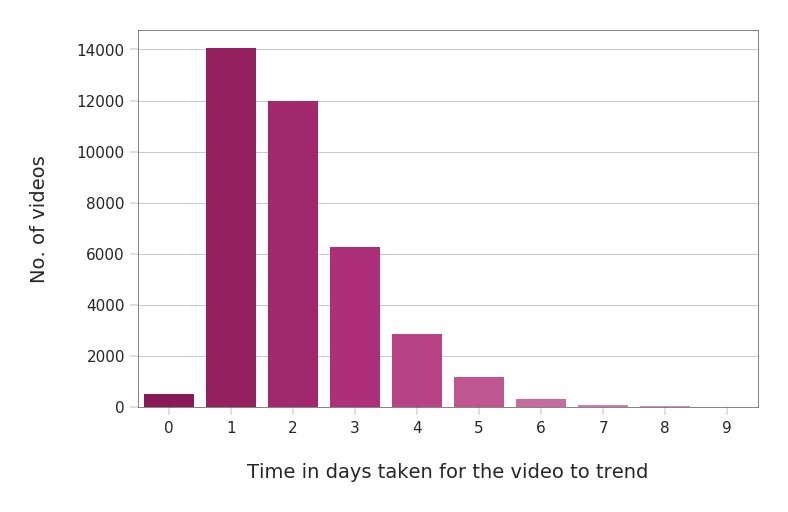

In [164]:
cdf = INvideos["diff"].value_counts().to_frame().reset_index()\
        .rename(columns={"index": "diff", "diff": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="diff", y="No_of_videos", data=cdf,palette=sns.color_palette("PiYG", 40), ax=ax)
_ = ax.set(xlabel="Time in days taken for the video to trend", ylabel="No. of videos")


We can see that it is very less likely that the video trends the same day it is published. Large number of videos trend after 1-2 days of release. Later, as the video gets old, very few of them trend. But after 9-10 days of release, the video won't be on the trending list. 

### Now, plotting a heatmap to analyse the trend duration of videos based on their categories

Text(0.5, 1, 'Category v/s Trending Duration')

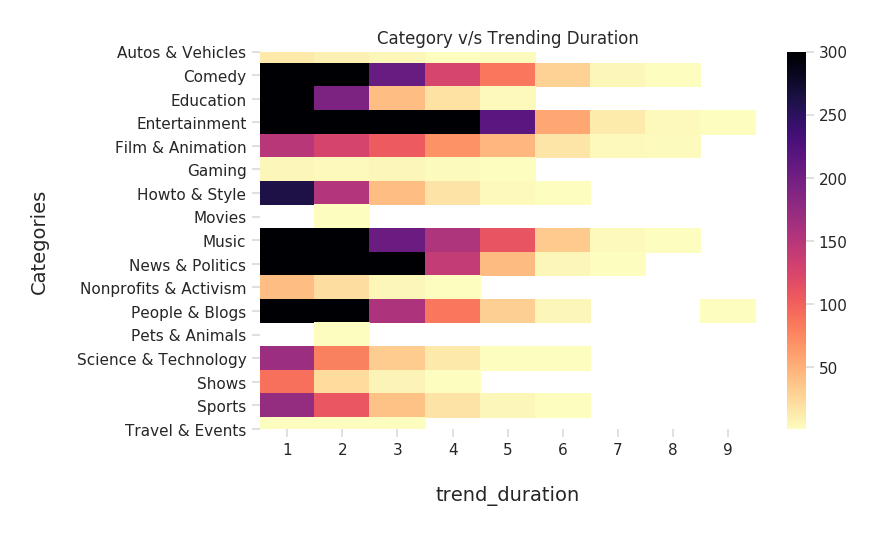

In [165]:
#last_entry has only the last occurence of the trended videos
#first_entry has only the first occurence of the trended videos
last_entry = INvideos.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='last')
first_entry = INvideos.reset_index().sort_values('trending_date').drop_duplicates('video_id',keep='first')
pub_to_trend = {}
for i, row in first_entry.iterrows():
    pub_to_trend[row['video_id']] = row['diff']
last_entry.insert(4, 'pub_to_trend', last_entry['video_id'].map(pub_to_trend))

# Creating a column 'trend_duration' which had the duration of the days the video has trended for.
last_entry.insert(4, 'trend_duration', 0)
last_entry['trend_duration'] = abs(last_entry['diff']-last_entry['pub_to_trend'])+1

# Plotting heatmap for Categories vs Trending duration of videos

cat_trend_dur= last_entry.groupby(['Categories','trend_duration']).count()['video_id'].unstack().clip(upper=300)
sns.heatmap(cat_trend_dur,cmap='magma_r')
plt.title("Category v/s Trending Duration")


From the heatmap, it can be observed that videos in entertainment category have relatively trended for a longer period. Larger number of videos in entertainment category atleast trend for 4 continuous days. Videos belonging to categories like comedy,film & animation and music also trend for a longer period.

But it can be seen that larger number of videos in categories like News & politics, People & Blogs and Education are in great trend for the first few days because they sell like hot cakes. They won't have the crisp later on. Same logic can be applied to videos belonging to Science & Technology , sports and Howto & style categories. It should be noted that these videos may be viewed later, but they won't be in trend.

Significant trend is not seen in other categories. One general conclusion is that in all categories, there are only a few videos which manage to trend for a longer period.

### *Top 10 trending channels :*

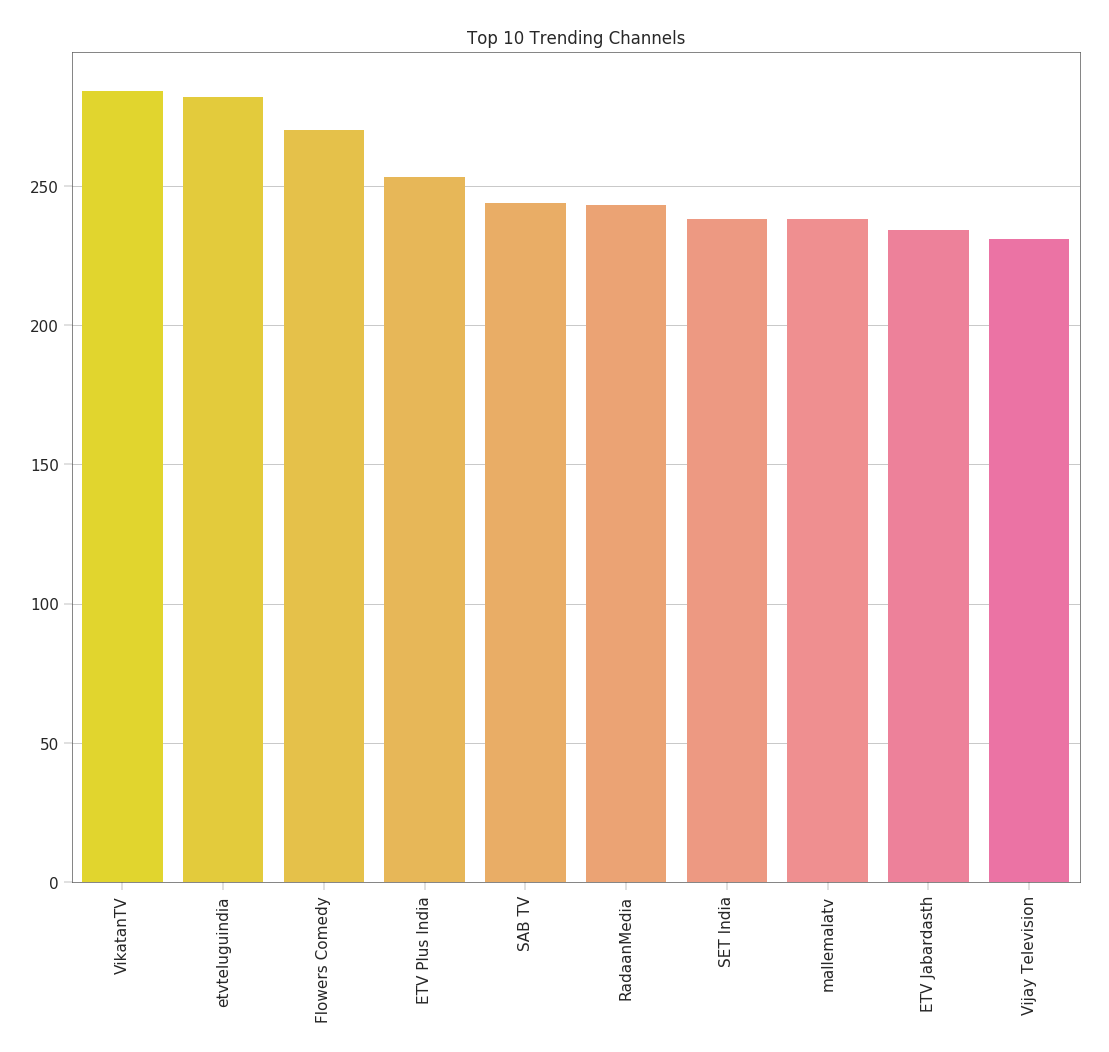

In [166]:
x = INvideos.channel_title.value_counts().head(10).index
y = INvideos.channel_title.value_counts().head(10).values
title = "Top 10 Trending Channels"
plt.figure(figsize = (13,11))
sns.barplot(x = x, y = y, palette=sns.color_palette('spring_r',15))
plt.title(title)
plt.xticks(rotation = 90)
plt.show()


We can see that most of the trending youtube channels are Television(TV) Channels ! We can infer that people are likely to go to YouTube and watch the content they missed out on TV.


# **Engagement of viewers**



## *Correlogram - to understand the correlation between different engagement features in the data.*

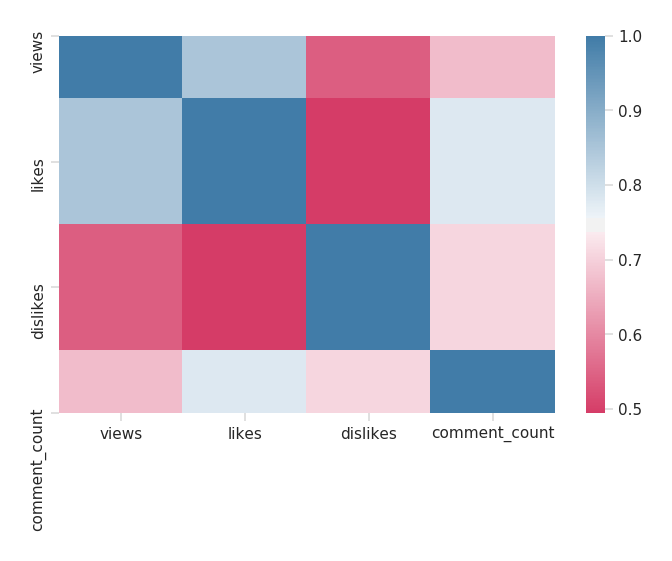

In [167]:
fig,ax = plt.subplots()
corr = INvideos[['views','likes','dislikes','comment_count']].corr()
sns.heatmap(corr,mask=np.zeros_like(corr, dtype=np.bool),cmap=sns.diverging_palette(1,600, as_cmap=True),ax=ax)

It can be seen that there is high correlation between views and likes. But not much can be seen between views and dislikes. From this it can be said that trending videos are more likely to be liked by the viewers than disliked.

To gain more insights like which category has more likes, which one is the hot cake, etc.. the likes, dislikes and comment rate distribution is plotted for each category below.

## *Analysing the percentage of likes, dislikes and comment by each category so as to know which category has the highest engagement.*

In [0]:
#We have divided by no. of views to normalize comparision.
INvideos['like_rate'] =  INvideos ['likes'] / INvideos['views'] * 100
INvideos['dislike_rate'] =  INvideos ['dislikes'] / INvideos['views'] * 100
INvideos['comment_rate'] =  INvideos ['comment_count'] / INvideos['views'] * 100

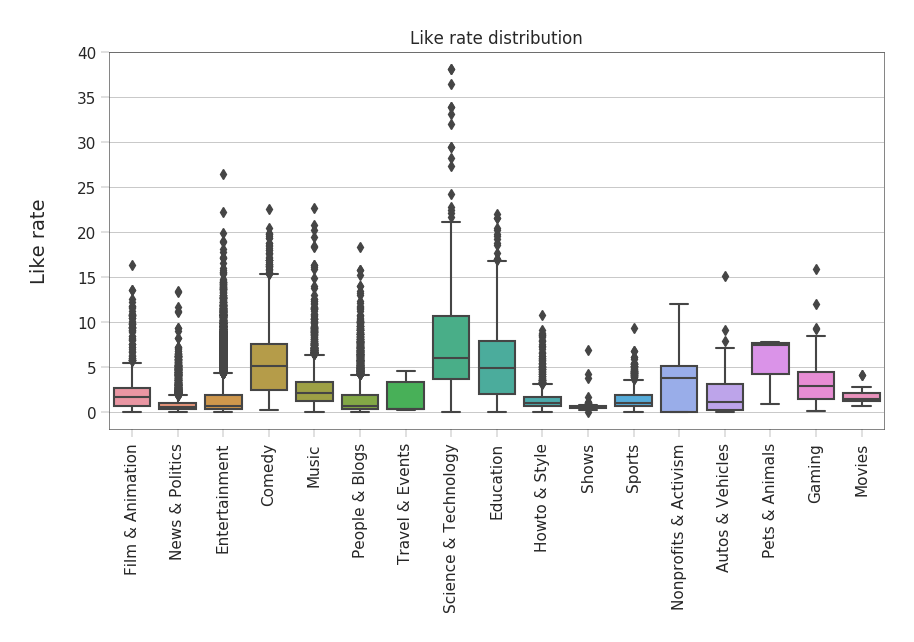

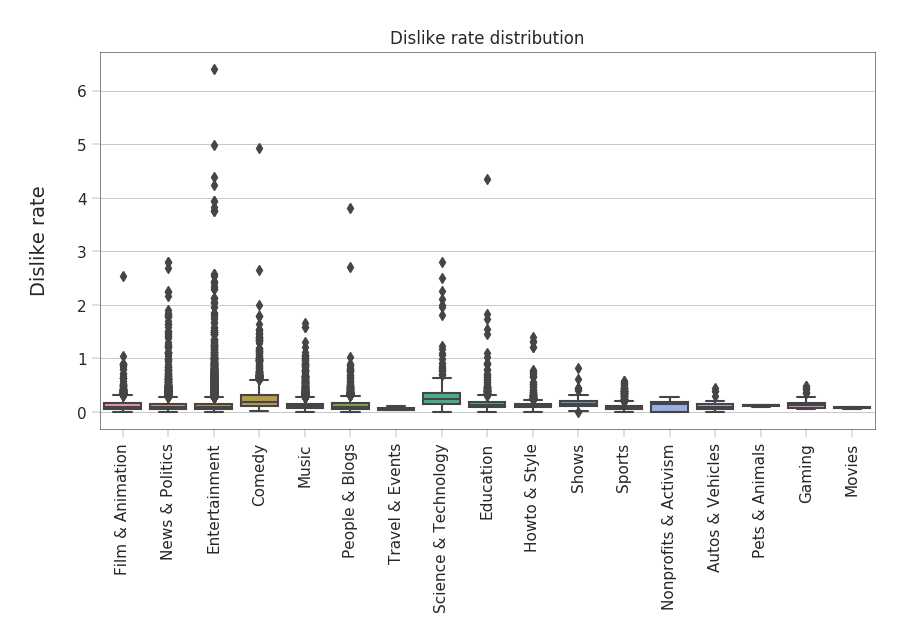

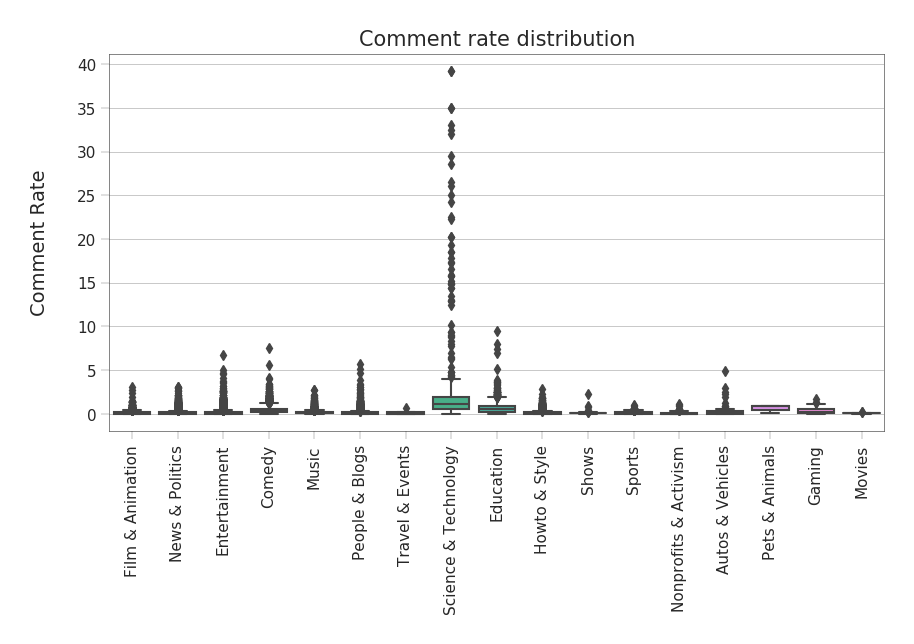

In [169]:
plt.figure(figsize = (10,5))
g= sns.boxplot(x='Categories',y='like_rate',  data=INvideos)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title("Like rate distribution")
g.set_xlabel("")
g.set_ylabel("Like rate")
plt.show()

plt.figure(figsize = (10,5))
g1= sns.boxplot( x='Categories',y='dislike_rate', data=INvideos)
g1.set_xticklabels(g.get_xticklabels(),rotation=90)
g1.set_title("Dislike rate distribution")
g1.set_xlabel("")
g1.set_ylabel("Dislike rate")
plt.show()

plt.figure(figsize = (10,5))
g2= sns.boxplot( x='Categories',y='comment_rate', data=INvideos)
g2.set_xticklabels(g.get_xticklabels(),rotation=90)
g2.set_title("Comment rate distribution", fontsize=15)
g2.set_xlabel("")
g2.set_ylabel("Comment Rate")
plt.show()

From the above boxplots, we can  mainly observe that :

Viewers like most of the science, education videos as like rate is relatively high.  


**Highest engagement is in the Science and Technology category.** We can say most of the viewers in this category are interactive as the comment rate is pretty high. Viewers are prone to discussion in this category as "Science is curious !" and there are many technological advancements which intrigue people. 

Dislike rate distribution for Entertainment, News & politics and comedy categories is evidently right-skewed, which can be interpreted as presence of critics. This maybe because the videos were not satisfying in case of Entertainment and comedy categories. People are very choosy when it comes to entertainment and what makes them happy. And unsurprisingly, it is no different when it comes to politics.

#**How does time and day of publishing affect the trending of videos ?**


## *Determining the day on which the videos published are most likely to be trending.*

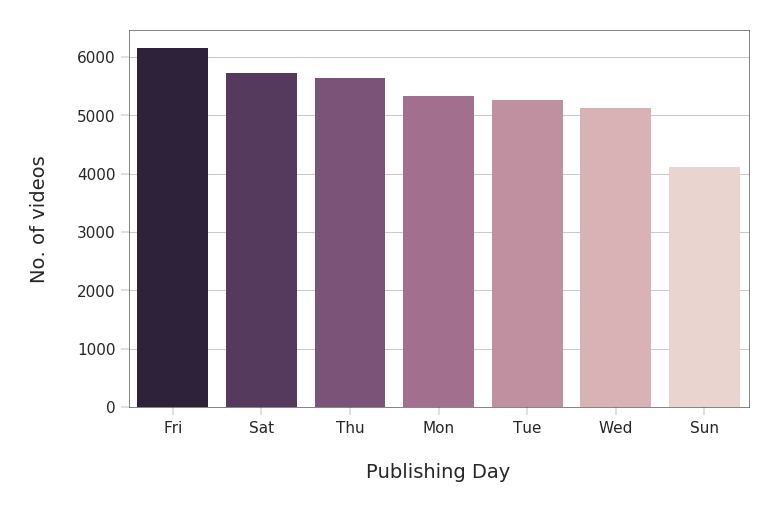

In [170]:
cdf = INvideos["publishing_day"].value_counts()\
        .to_frame().reset_index().rename(columns={"index": "publishing_day", "publishing_day": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_day", y="No_of_videos", data=cdf, 
                palette=sns.cubehelix_palette(reverse=True,n_colors=7), ax=ax)
_ = ax.set(xlabel="Publishing Day", ylabel="No. of videos")


We can see that the number of trending videos published on Sunday is the least owing to *Monday Blues*. So, it is suggested to not publish videos on Sunday if we want them to trend. 

On the other hand, the videos released on friday are most likely to be trending on YouTube. One of the reason for this could be the following weekend when the user interaction increases and videos have greater chances of becoming viral.
Hence, it is advisable to publish videos on friday or saturday as it has relatively high probability to trend.



##*Which publishing hours had the largest number of trending videos ?*



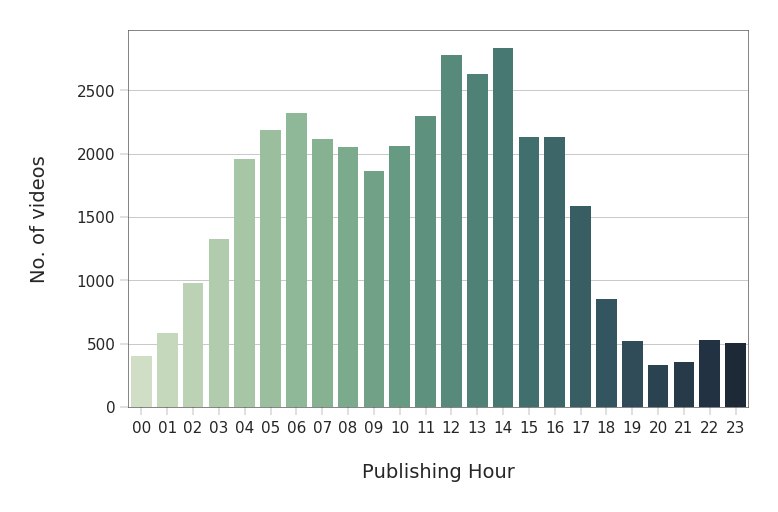

In [171]:
cdf = INvideos["publishing_hour"].value_counts().to_frame().reset_index()\
        .rename(columns={"index": "publishing_hour", "publishing_hour": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_hour", y="No_of_videos", data=cdf, 
                palette=sns.cubehelix_palette(rot=-.5,n_colors=24), ax=ax)
_ = ax.set(xlabel="Publishing Hour", ylabel="No. of videos")


We can see that the period between 11AM and 4PM, peaking at 12PM and 2PM, has the largest number of trending videos. We also notice that the period between 7PM and 12AM has the smallest number of trending videos. Therefore it can be said that publishing videos in the afternoon-early evening is more likely to trend as people view it mostly in the late evening (time for relaxation).  

#**Textual Analysis**
## Analysing titles of trending videos
### *Wordcloud on titles of trending videos :*

In [0]:
def createwordcloud(data, title):
    plt.figure(figsize = (13,14))
    wc = WordCloud(width=1200, height=600, 
                         collocations=False,stopwords = STOPWORDS, background_color="white", 
                         colormap="tab20b").generate(" ".join(data))
    plt.figure(figsize=(12,10))
    plt.imshow(wc)
    _ = plt.axis("off")

<Figure size 1300x1400 with 0 Axes>

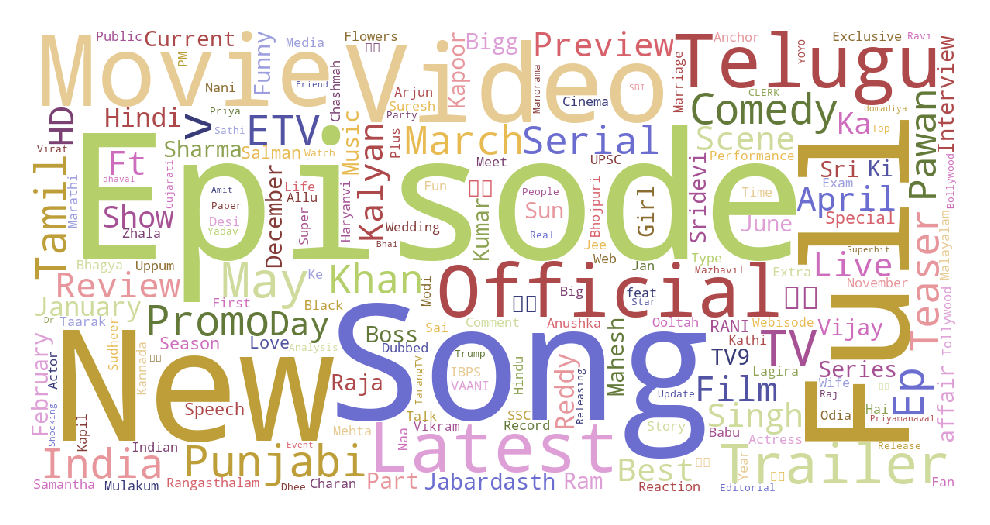

In [173]:
title = INvideos['title']
createwordcloud(title , 'Commonly used words in titles' )

Based on title, we can say that , most of the trending videos were mainly **full episodes of soaps/web series** . We can conclude YouTube webseries trend greatly. 

**Songs and official trailers of movies** also trend when they get released. We can even say quite a large number of trending videos were in regional languages like Telugu, Tamil and Punjabi. 

To gain more insights, we have plotted bigrams for each category :

### *Bigrams on title of trending videos :*

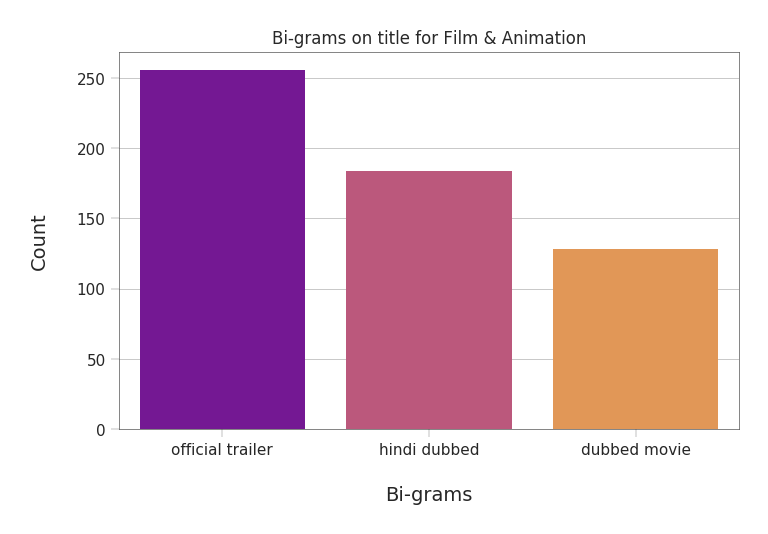

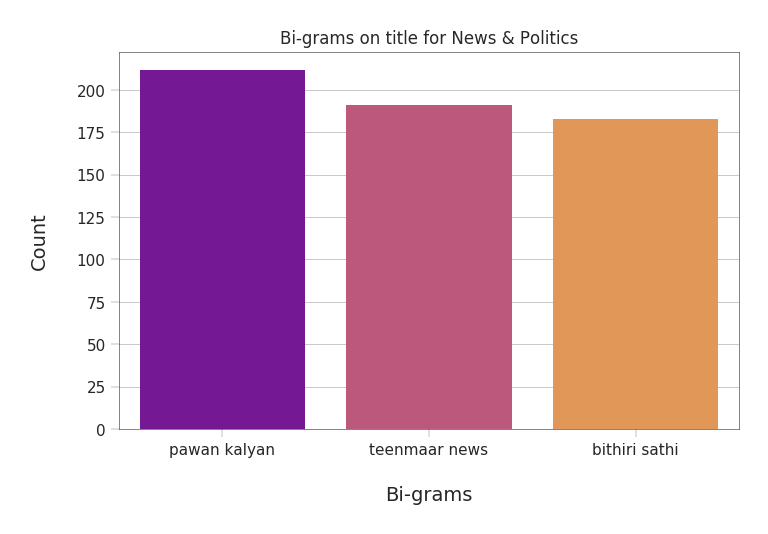

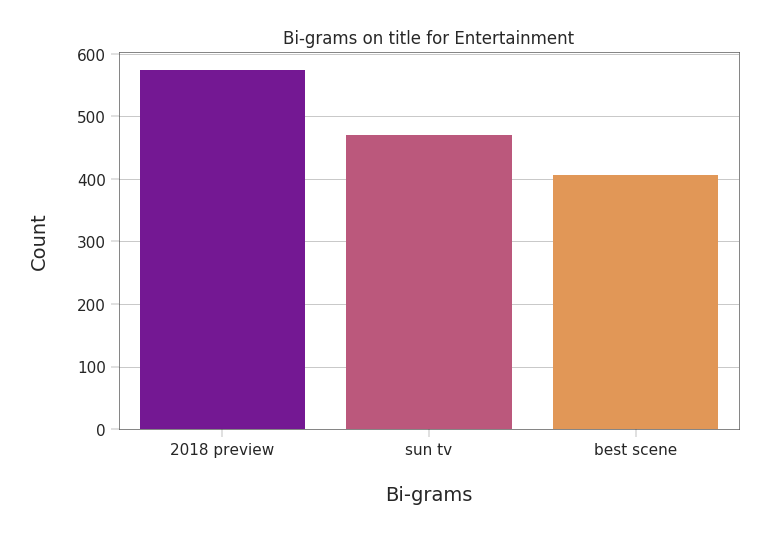

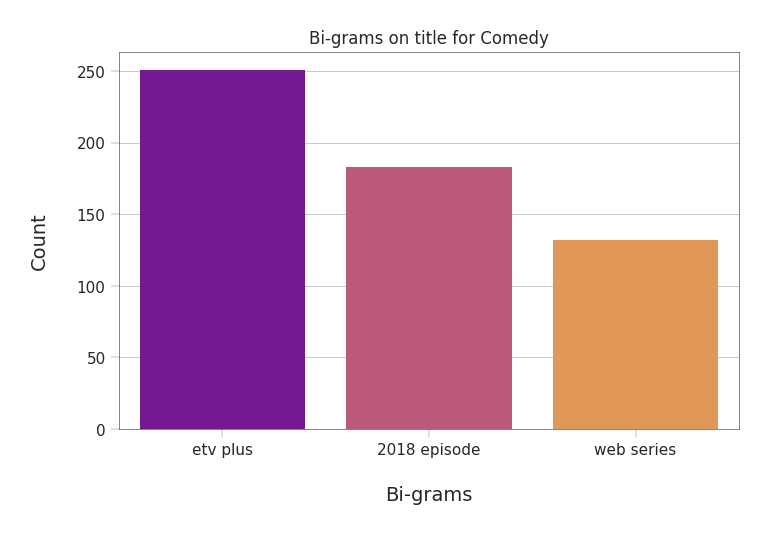

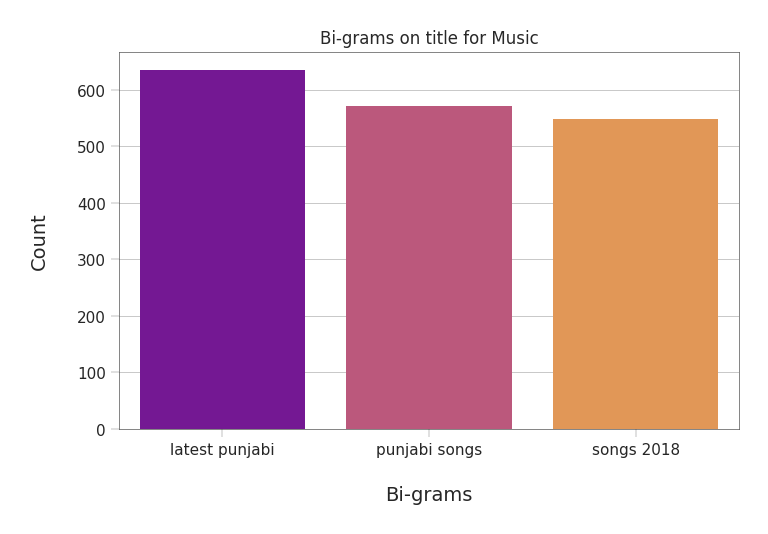

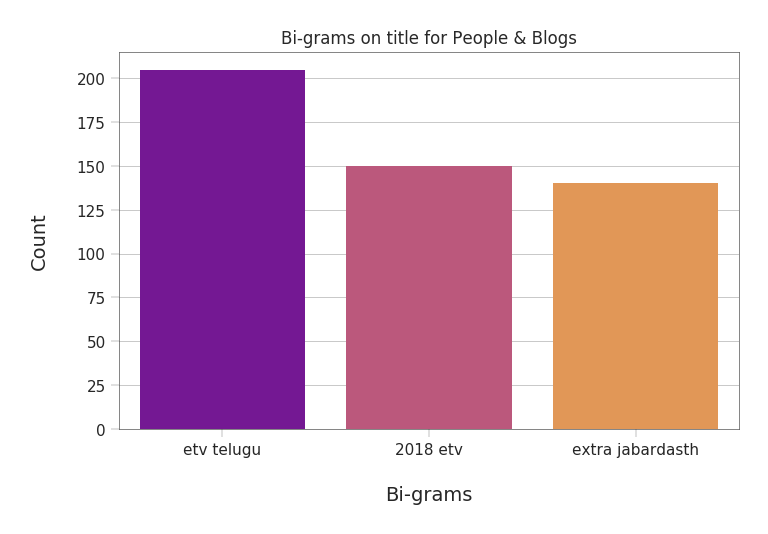

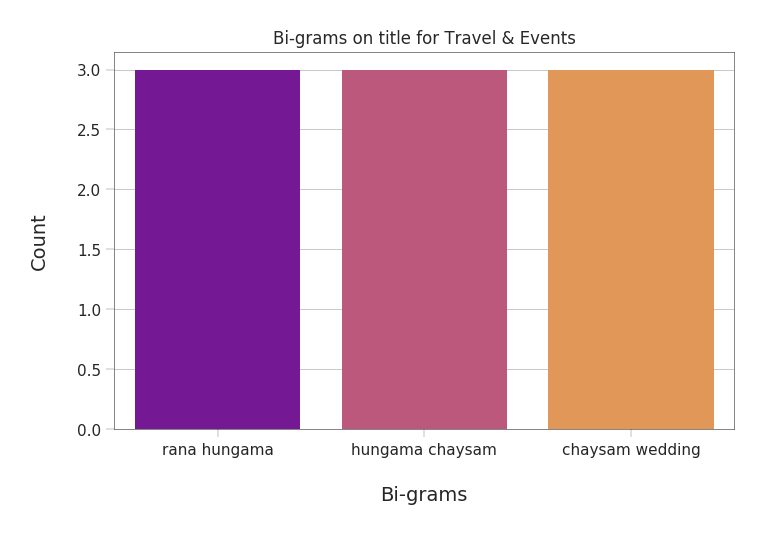

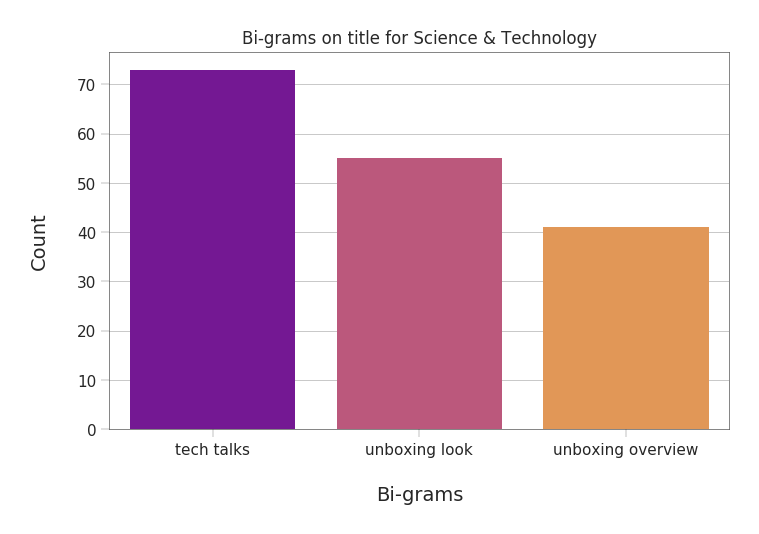

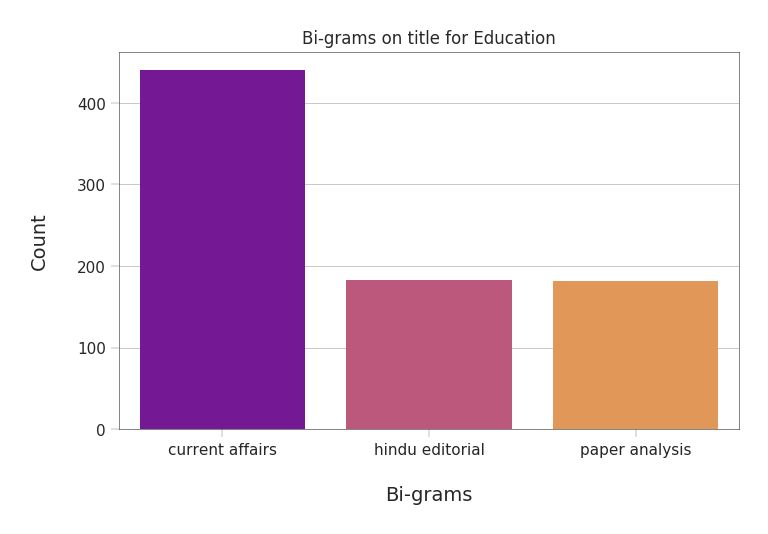

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2348 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2344 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 2323 missing from current font.
  font.set_text(s

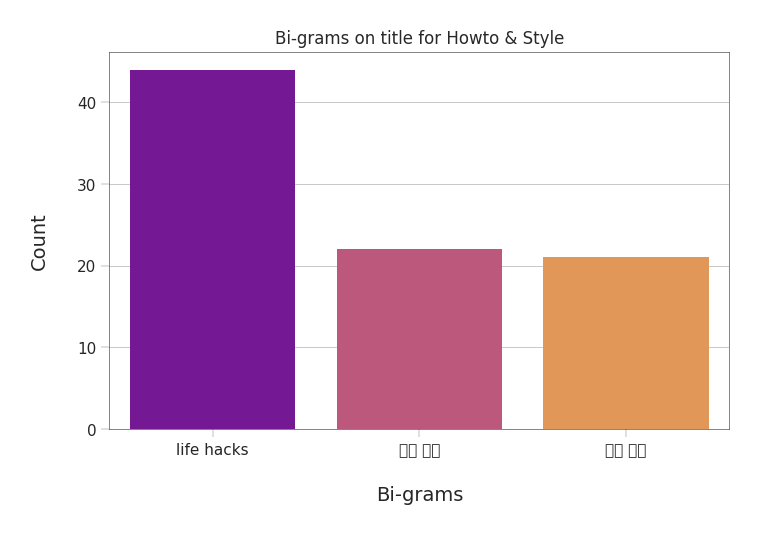

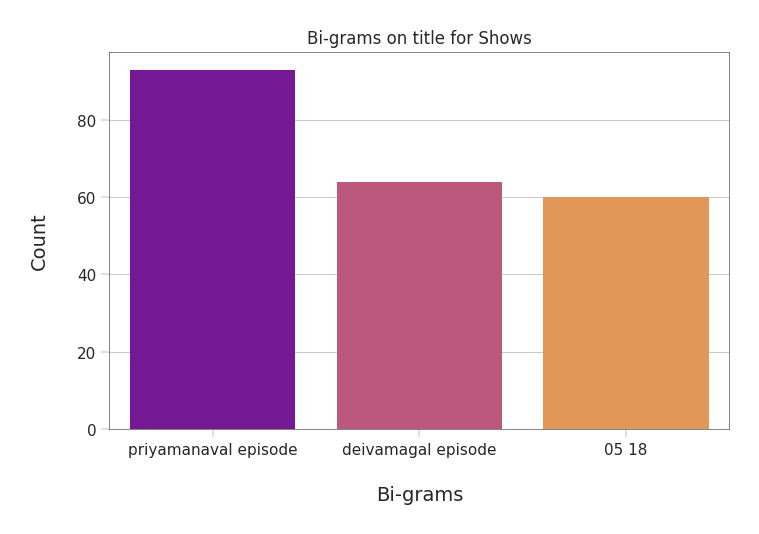

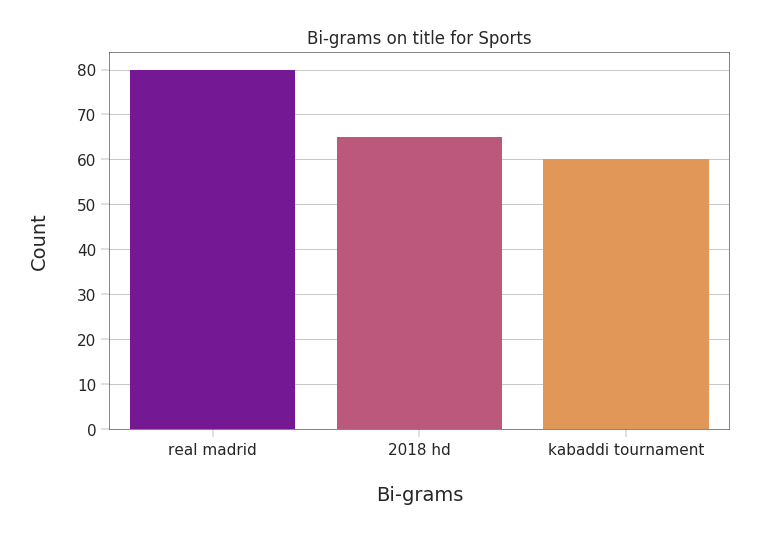

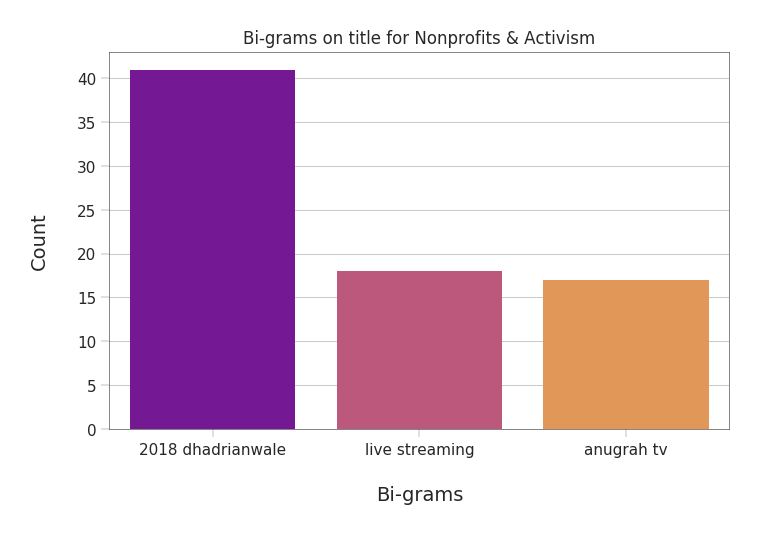

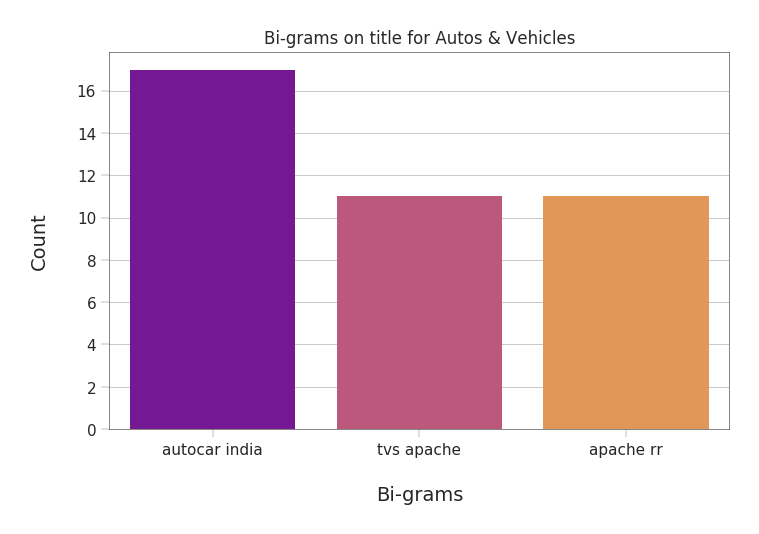

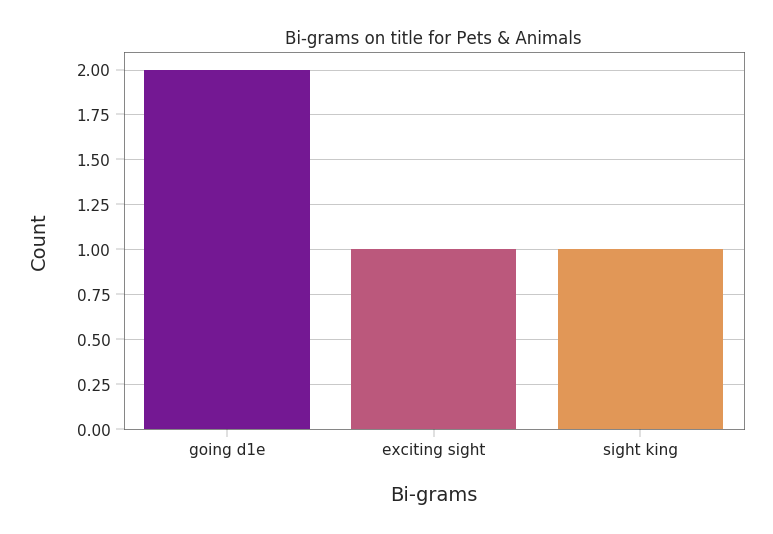

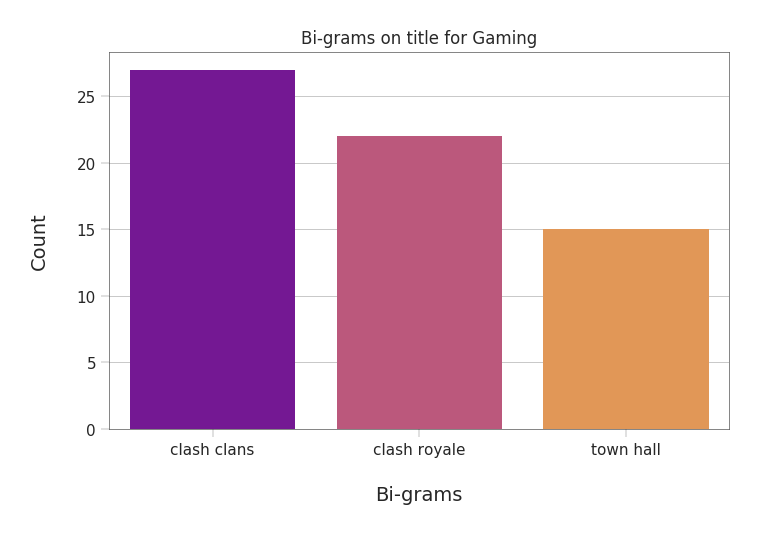

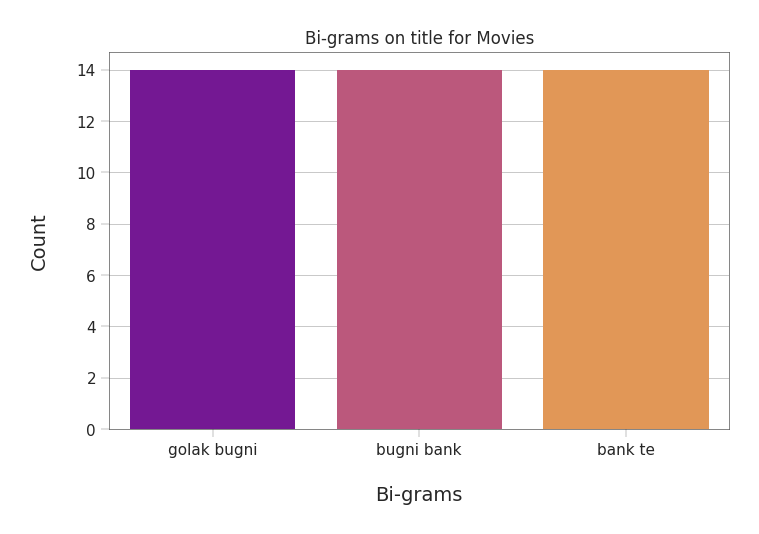

In [174]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

catlist = INvideos['Categories'].unique()
for c in catlist:
    dep_words = INvideos[INvideos['Categories']==c]['title']  
    common_words = get_top_n_bigram(dep_words, 3)
    
    df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
    plt.figure()
    title="Bi-grams on title for " + c
    ax = sns.barplot(x=df4['ReviewText'],y=df4['count'],orient='v',palette="plasma")
    plt.ylabel("Count")
    plt.xlabel("Bi-grams")
    plt.title(title)

(There is a small warning because the Devanagari font (hindi words) is missing in matplotlib.)

#### Above plots gives the top 3 bi-grams on title for each category. From this we can infer what are the type of videos that usually trend in each category. It may indicate the channel or subcategory of the videos as videos becoming viral usually have those bi-grams in their title. 

## Analysing tags of trending videos :
### *Wordcloud on Tags of Trending videos :*

<Figure size 1300x1400 with 0 Axes>

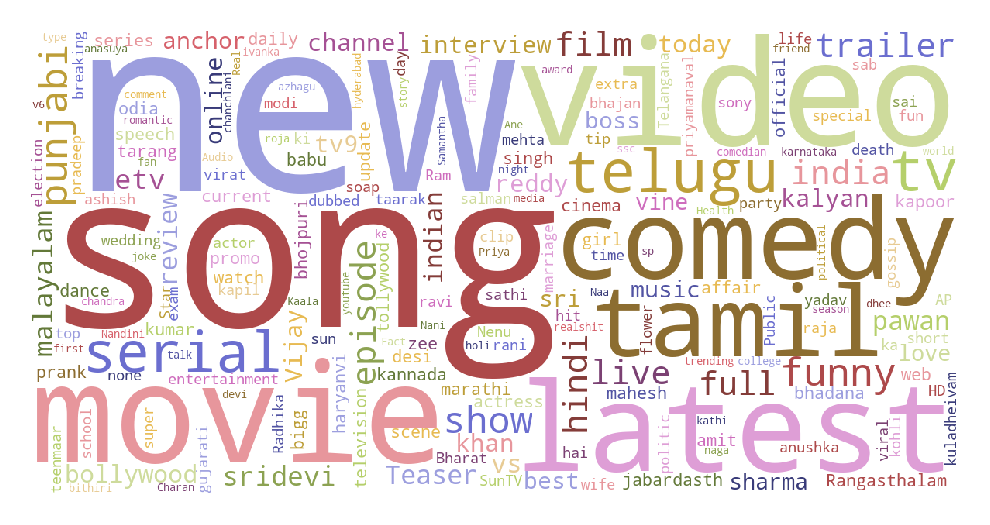

In [175]:
tags = INvideos['tags']
createwordcloud(tags , 'Commonly used tags in trended videos' )

Videos with **Latest/new** tags have trended the most, followed by songs, movies and comedy videos. Even from tags, we can say that most of the videos that trended were in **regional languages** :tamil, telugu or punjabi. The wordcloud is dominated by the aentertainment category. 

So, to gain much deeper insights, we have calculated polarity scores of tags in each category .

### *Polarity (emotions expressed in a sentence) of tags in each category*


Text(0.5, 1.0, 'Polarity of tags in each Categories')

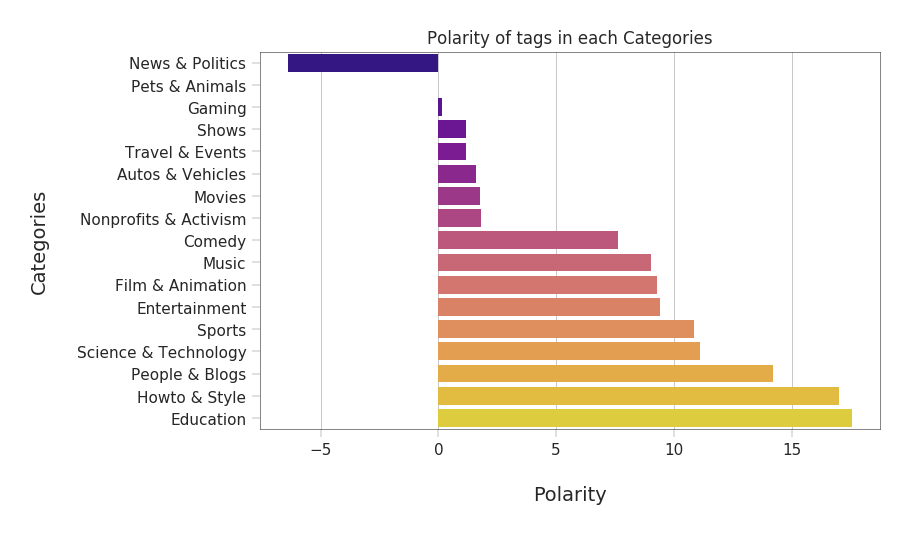

In [177]:
#1500 most common tags are considered in calculating polarity scores using NLTK sentiment analyzer

en_stopwords = list(stopwords.words('english'))
polarity = list()
catlist = INvideos['Categories'].unique()
for c in catlist:
    dep_words = INvideos[INvideos['Categories']==c]['tags'].str.lower().str.cat(sep=' ')
    tokens = word_tokenize(dep_words)
    filtered1 = [w for w in tokens if not w in en_stopwords]
    filtered2 = [w for w in filtered1 if w.isalnum()] # removes punctuation,numbers and returns list of words
    final = [w for w in filtered2 if not w.isdigit()] # removing numbers
    N=len(final)
    dist = nltk.FreqDist(final)
    word_freq = pd.DataFrame(dist.most_common(1500),
                    columns=['Word', 'Frequency'])
    compound = .0
    for word in word_freq['Word'].head(1500):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']
    polarity.append(compound)

catlist = pd.DataFrame(catlist)
polarity = pd.DataFrame(polarity)
sentiment = pd.concat([catlist,polarity],axis=1)
sentiment.columns = ['Category','Polarity']
sentiment=sentiment.sort_values('Polarity').reset_index()


ax = sns.barplot(x=sentiment['Polarity'],y=sentiment['Category'], data=sentiment,orient='h',palette="plasma")
plt.ylabel("Categories")
plt.xlabel("Polarity")
plt.title("Polarity of tags in each Categories")

Negative values of polarity indicate most of the tags among the 1500 frequent ones, have negative sentiment. Positive values indicate majority of positive sentiments.

It is not surprising that most of the tags in News & politics videos are negative. And it is quite impressive that tags of videos in education category has the highest positive score.


# **Comparing trend across countries :**
### (*The countries included are India, Germany, France, Canada, USA, Great Britain*)


## *Category analysis with respect to countries :*



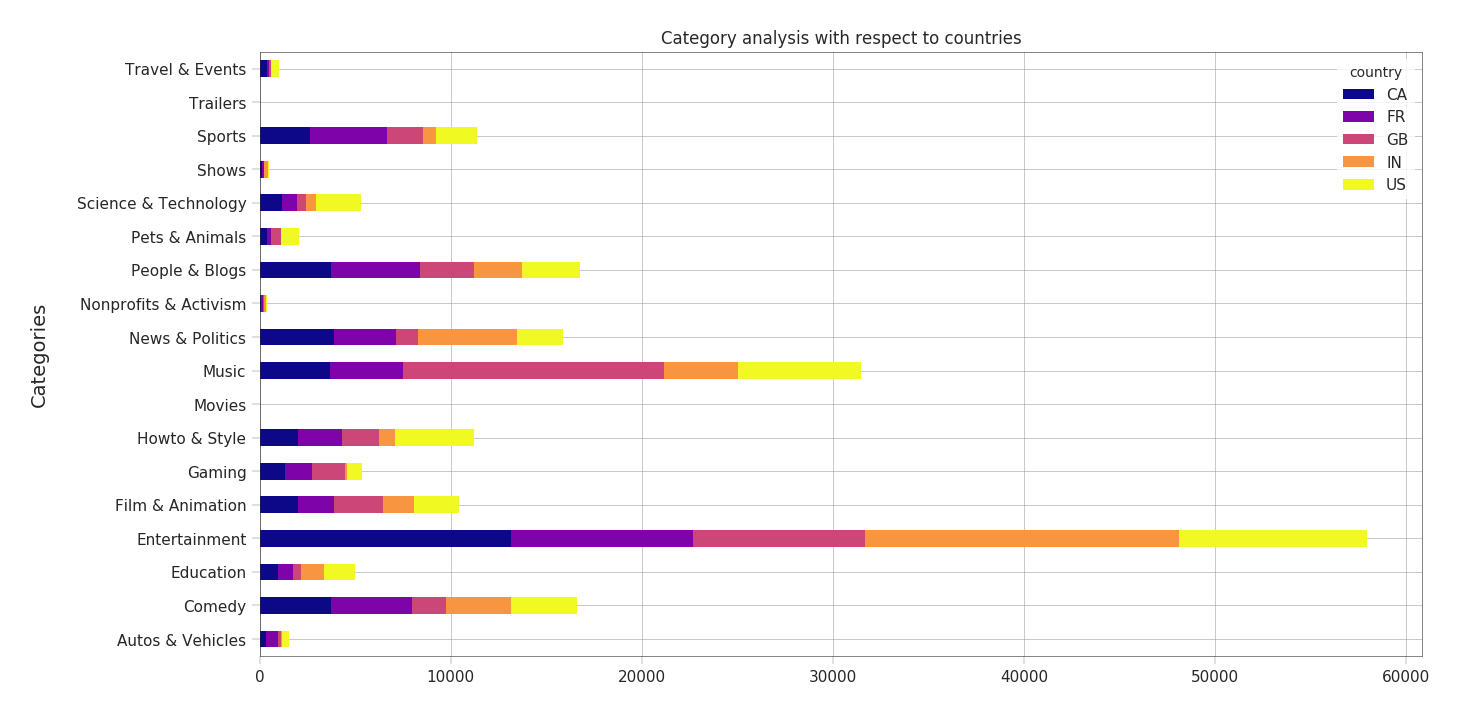

In [178]:
#loading the datasets :
fil = ['We-R/YouTube_dataset/CAvideos.csv','We-R/YouTube_dataset/FRvideos.csv', 'We-R/YouTube_dataset/GBvideos.csv', 'We-R/YouTube_dataset/INvideos.csv', 'We-R/YouTube_dataset/USvideos.csv']

ycd_initial = list()
for csv in fil:
    ycd_partial = pd.read_csv(csv)
    ycd_partial['country'] = csv[21:23] #Adding the new column as "country"
    ycd_initial.append(ycd_partial)
    
ycd = pd.concat(ycd_initial)
ycd.apply(lambda x: sum(x.isnull()))
column_list=[] 
for column in ycd.columns:
    column_list.append(column)

# Drop NA values
ycd.dropna(subset=column_list, inplace=True) 

ycd['Categories'] = [category[x] for x in ycd['category_id']]

ycd.groupby(["Categories","country"]).count()["video_id"].unstack().plot.barh(figsize=(15,8), stacked=True, cmap = "plasma")
plt.title("Category analysis with respect to countries")
plt.show()


##### The top trending category is Entertainment in Canada, France, India and USA. But in Great Britain, it is Music. Maybe the population is inclined more towards music .

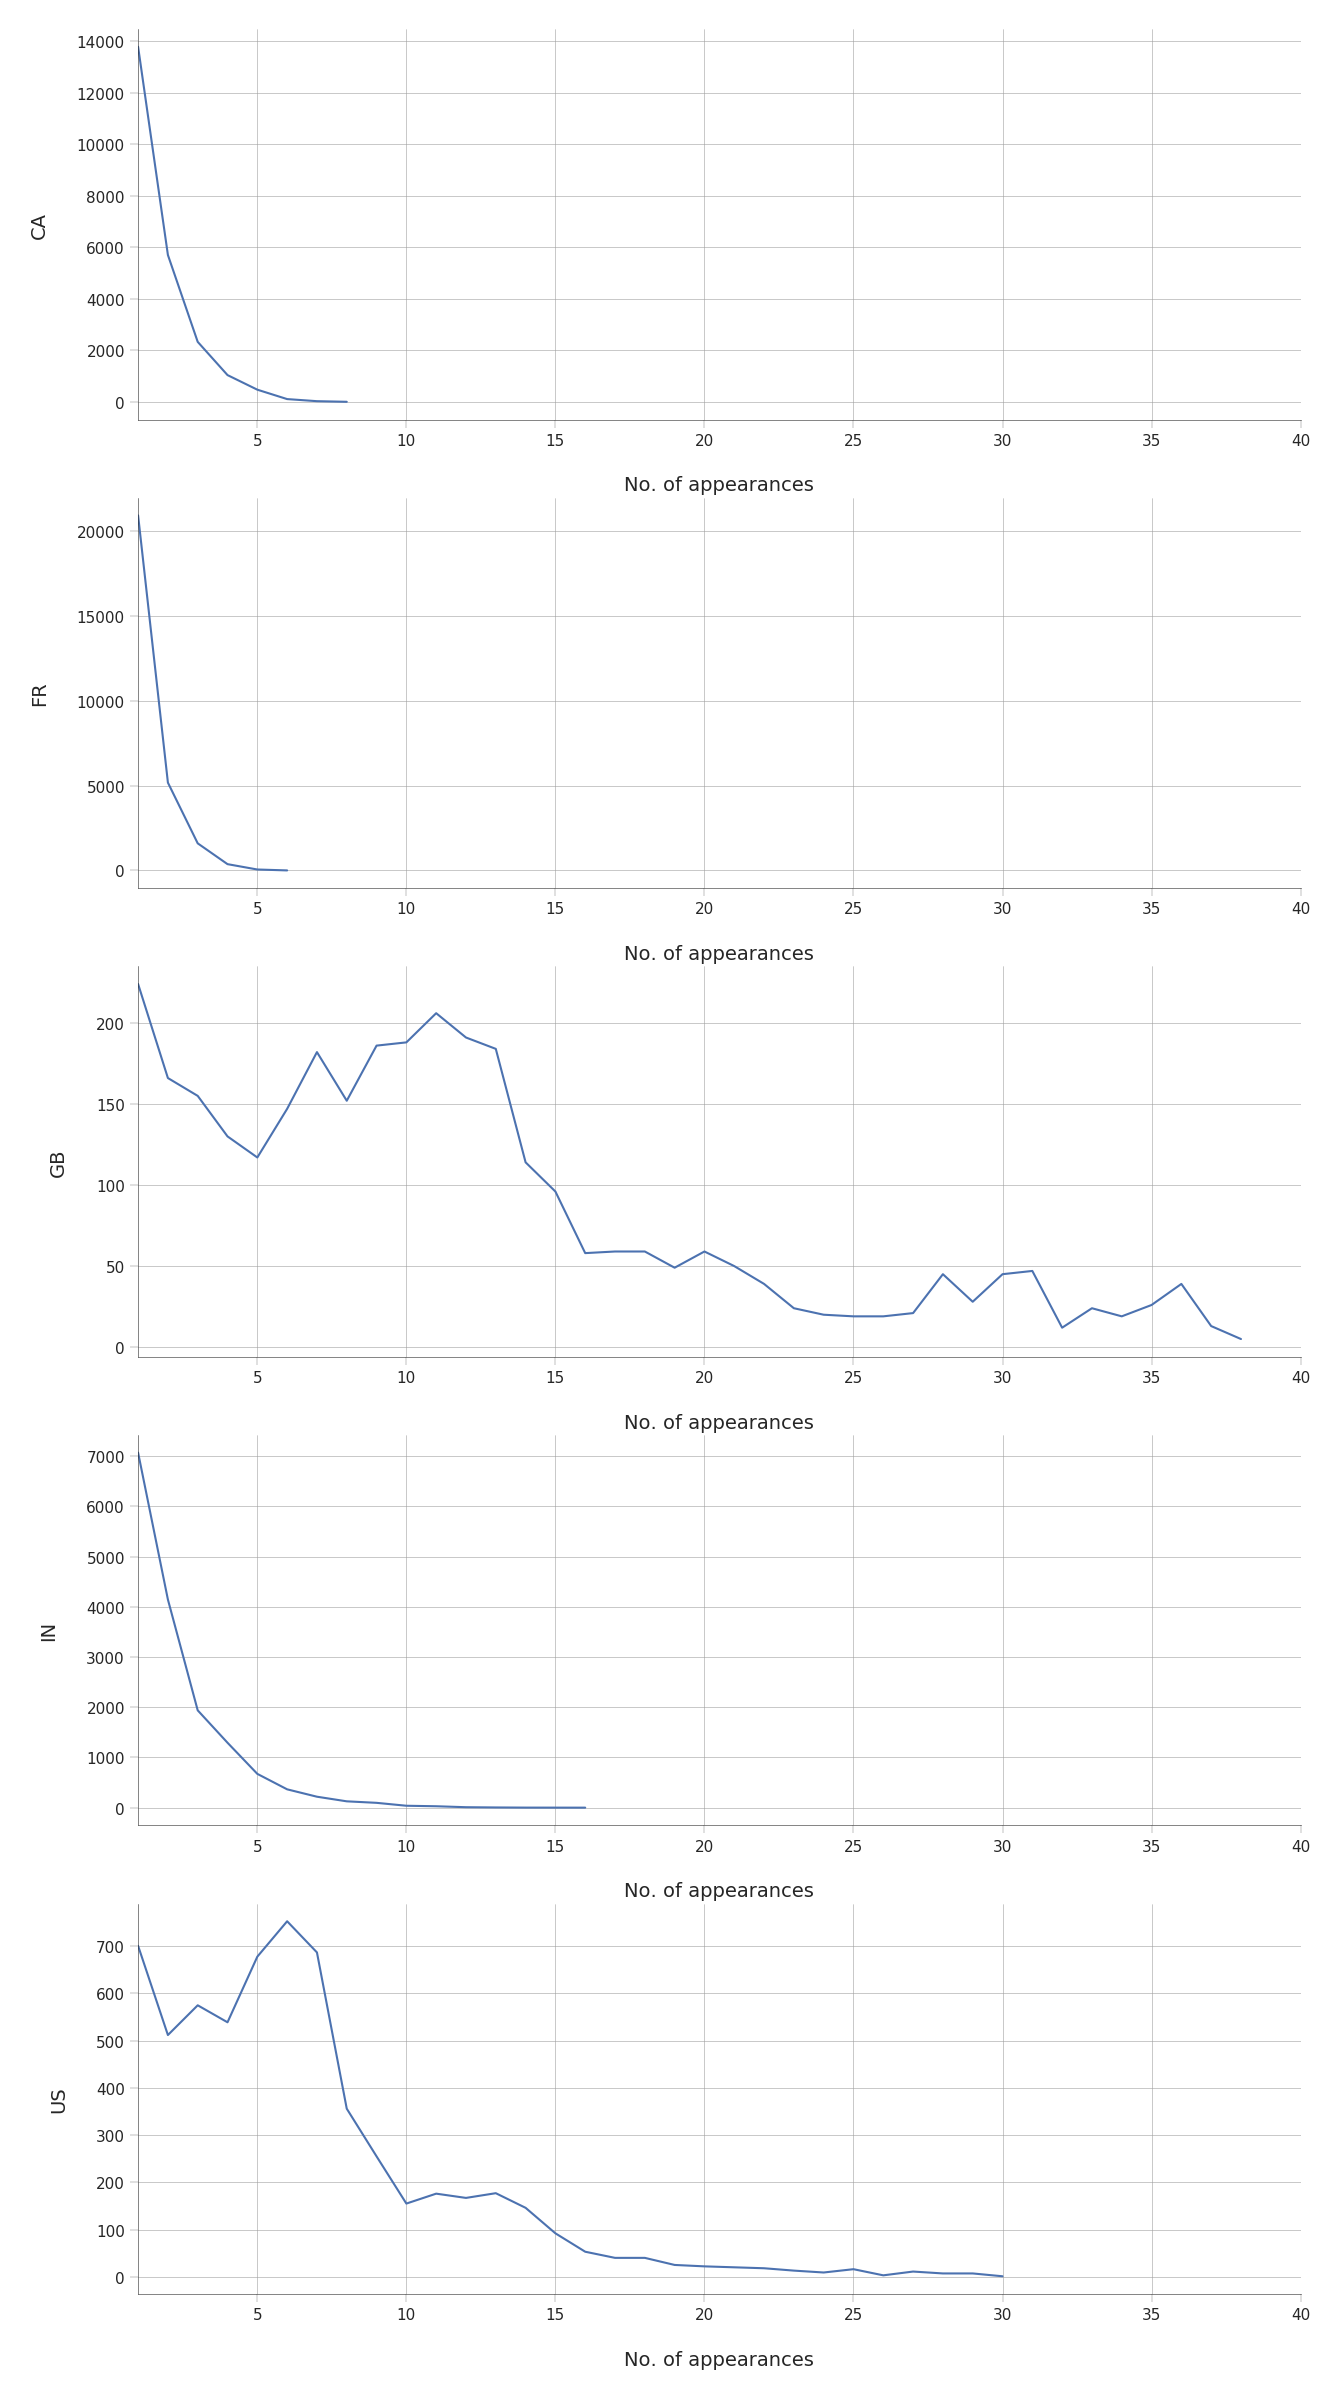

In [179]:
df = pd.DataFrame(ycd.groupby([ycd.video_id,'country']).count()['title'].sort_values(ascending=False)).reset_index()
df = df[1:]
video_list,max_list = list(),list()
country_list = ycd.groupby(['country']).count().index

for c in country_list:
    video_list.append(df[df['country']==c]['title'].value_counts().sort_index())
    max_list.append(max(df[df['country']==c]['title'].value_counts().sort_index().index))

fig, [ax0, ax1, ax2, ax3, ax4] = plt.subplots(nrows=5,figsize=(15, 30))

for i, pt in enumerate([ax0, ax1, ax2, ax3, ax4]):
    pt.plot(video_list[i].index, video_list[i])
    pt.spines['right'].set_visible(False)
    pt.spines['top'].set_visible(False)
    pt.set_xlabel("No. of appearances")
    pt.set_ylabel(country_list[i])
    pt.axes.set_xlim(1, 40)

plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0)

From the line graphs above we can see that Great Britan has numbers of enduring video in trend follow by US. In contrast, both Canada and France have very few videos that last long in trending list with max of 5 appearances in statistics. India falls in the middle with max of 16 days trend.